# Install Libraries

In [1]:
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir
! pip uninstall opencv-python
! pip install opencv-python==4.5.2.54

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-hqhwtea0
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-hqhwtea0
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112538 sha256=4b4e261f51de1c5831f90408717defb15ef8519ce722e7cdbca425f9394a458f
  Stored in directory: /tmp/pip-ephem-wheel-cache-u39h9y1w/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
  Would not remove

In [2]:
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision.datasets.vision import VisionDataset
from torchvision import transforms
import pathlib
from copy import deepcopy
import cv2
import albumentations as albu
import matplotlib.pyplot as plt
import time
import copy

# Define Paths

In [5]:
data_dir = '/content/drive/My Drive/Remote Sensing Image Analysis/assignment2/report2/data/'
model_dir = '/content/drive/My Drive/Remote Sensing Image Analysis/assignment2/report2/model/'
pred_dir = '/content/drive/My Drive/Remote Sensing Image Analysis/assignment2/report2/result/'

x_train_dir = os.path.join(data_dir, 'train_img')
y_train_dir = os.path.join(data_dir, 'train_label')

x_val_dir = os.path.join(data_dir, 'val_img')
y_val_dir = os.path.join(data_dir, 'val_label')

# Define Configurations

In [6]:
batch_size = 8
epochs = 60
img_size = 256
prediction_threshold = 0.5
in_ch = 3 # number of input channels (RGB)
out_ch = 1 # number of output channels (1 for binary classification)
prediction_threshold = 0.5
model_name = 'manet_final'
model_file = "%s_E%d_B%d.pth"%(model_name, epochs, batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Dataset Class

In [7]:
# Reference: https://github.com/qubvel/segmentation_models.pytorch

class SemanticSegmentationDataset(VisionDataset):
    CLASSES = [
        "nonbuilding",
        "building",
    ]

    def __init__(
        self,
        train_images_dir,
        train_masks_dir,
        val_images_dir,
        val_masks_dir,
        augmentation=None,
        classes=None
    ):
        self.train_images_dir = train_images_dir
        self.train_masks_dir = train_masks_dir
        self.val_images_dir = val_images_dir
        self.val_masks_dir = val_masks_dir
        self.rgb_list = self._get_rgb_list()

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.augmentation = augmentation

    def _get_rgb_list(self):
        return list(sorted(pathlib.Path(self.train_images_dir).glob("*.png"))) + list(sorted(pathlib.Path(self.val_images_dir).glob("*.png")))

    def __len__(self):
        return len(self.rgb_list)

    def __getitem__(self, index):
        rgb_path = self.rgb_list[index]
        rgb_fname = rgb_path.stem
        str_rgb_path = str(rgb_path)
        phase = str_rgb_path.split('/')[-2]

        if phase == 'train_img':
            cls_path = os.path.join(self.train_masks_dir, rgb_fname + '.png')
        elif phase == 'val_img':
            cls_path = os.path.join(self.val_masks_dir, rgb_fname + '.png')
        else:
          raise Exception(f"Phase is unknown: {phase}")

        #image = imread(str(rgb_path))
        image = cv2.imread(str(rgb_path), cv2.IMREAD_COLOR)

        #mask = imread(str(cls_path))
        mask = cv2.imread(str(cls_path), cv2.IMREAD_UNCHANGED)
        mask[mask < 255] = 0  # non-buildings
        mask[mask == 255] = 1  # buildings
        mask = mask.astype('int64')

        # extract certain classes from mask (e.g. building)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('int64')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask, str(rgb_path)

# Define Augmentation Helper Functions

In [8]:
# Reference: https://github.com/albumentations-team/albumentations

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def to_tensor_labels(x, **kwargs):
    return x.transpose(2, 0, 1).astype('int64')

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.RandomCrop(height=img_size, width=img_size, p=0.5),
        albu.Resize(img_size,img_size),
        albu.Lambda(image=to_tensor,mask=to_tensor)
    ]

    return albu.Compose(train_transform)

def get_val_augmentation():
    test_transform = [
        albu.Resize(img_size,img_size),
        albu.Lambda(image=to_tensor,mask=to_tensor)
    ]

    return albu.Compose(test_transform)

def get_IoU(pred_mask, mask, eps=1e-10):
    iou = None

    with torch.no_grad():
        intersection = torch.sum(mask * pred_mask)
        union = torch.sum(mask) + torch.sum(pred_mask) - intersection + eps
        iou = (intersection + eps) / union

    return iou

# Define Model Class

In [9]:
# Reference: https://github.com/lironui/Multi-Attention-Network/blob/master/MANet.py

import torch.nn.functional as F
from torch.nn import Module, Conv2d, Parameter, Softmax
from torchvision.models import resnet
import torch
from torchvision import models
from torch import nn

from functools import partial


nonlinearity = partial(F.relu, inplace=True)


def softplus_feature_map(x):
    return torch.nn.functional.softplus(x)


def conv3otherRelu(in_planes, out_planes, kernel_size=None, stride=None, padding=None):
    # 3x3 convolution with padding and relu
    if kernel_size is None:
        kernel_size = 3
    assert isinstance(kernel_size, (int, tuple)), 'kernel_size is not in (int, tuple)!'

    if stride is None:
        stride = 1
    assert isinstance(stride, (int, tuple)), 'stride is not in (int, tuple)!'

    if padding is None:
        padding = 1
    assert isinstance(padding, (int, tuple)), 'padding is not in (int, tuple)!'

    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=True),
        nn.ReLU(inplace=True)  # inplace=True
    )


class PAM_Module(Module):
    def __init__(self, in_places, scale=8, eps=1e-6):
        super(PAM_Module, self).__init__()
        self.gamma = Parameter(torch.zeros(1))
        self.in_places = in_places
        self.softplus_feature = softplus_feature_map
        self.eps = eps

        self.query_conv = Conv2d(in_channels=in_places, out_channels=in_places // scale, kernel_size=1)
        self.key_conv = Conv2d(in_channels=in_places, out_channels=in_places // scale, kernel_size=1)
        self.value_conv = Conv2d(in_channels=in_places, out_channels=in_places, kernel_size=1)

    def forward(self, x):
        # Apply the feature map to the queries and keys
        batch_size, chnnels, width, height = x.shape
        Q = self.query_conv(x).view(batch_size, -1, width * height)
        K = self.key_conv(x).view(batch_size, -1, width * height)
        V = self.value_conv(x).view(batch_size, -1, width * height)

        Q = self.softplus_feature(Q).permute(-3, -1, -2)
        K = self.softplus_feature(K)

        KV = torch.einsum("bmn, bcn->bmc", K, V)

        norm = 1 / torch.einsum("bnc, bc->bn", Q, torch.sum(K, dim=-1) + self.eps)

        # weight_value = torch.einsum("bnm, bmc, bn->bcn", Q, KV, norm)
        weight_value = torch.einsum("bnm, bmc, bn->bcn", Q, KV, norm)
        weight_value = weight_value.view(batch_size, chnnels, height, width)

        return (x + self.gamma * weight_value).contiguous()


class CAM_Module(Module):
    def __init__(self):
        super(CAM_Module, self).__init__()
        self.gamma = Parameter(torch.zeros(1))
        self.softmax = Softmax(dim=-1)

    def forward(self, x):
        batch_size, chnnels, width, height = x.shape
        proj_query = x.view(batch_size, chnnels, -1)
        proj_key = x.view(batch_size, chnnels, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy) - energy
        attention = self.softmax(energy_new)
        proj_value = x.view(batch_size, chnnels, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(batch_size, chnnels, height, width)

        out = self.gamma * out + x
        return out


class PAM_CAM_Layer(nn.Module):
    def __init__(self, in_ch):
        super(PAM_CAM_Layer, self).__init__()
        self.PAM = PAM_Module(in_ch)
        self.CAM = CAM_Module()

    def forward(self, x):
        return self.PAM(x) + self.CAM(x)


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(DecoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity

        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x


class MANet(nn.Module):
    def __init__(self, num_channels=3, num_classes=5):
        super(MANet, self).__init__()
        self.name = 'MANet'

        filters = [256, 512, 1024, 2048]
        resnet = models.resnet50(pretrained=True)
        self.firstconv = resnet.conv1
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.attention4 = PAM_CAM_Layer(filters[3])
        self.attention3 = PAM_CAM_Layer(filters[2])
        self.attention2 = PAM_CAM_Layer(filters[1])
        self.attention1 = PAM_CAM_Layer(filters[0])

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[0], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x1 = self.firstconv(x)
        x1 = self.firstbn(x1)
        x1 = self.firstrelu(x1)
        x1 = self.firstmaxpool(x1)
        e1 = self.encoder1(x1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        e4 = self.attention4(e4)

        # Decoder
        d4 = self.decoder4(e4) + self.attention3(e3)
        d3 = self.decoder3(d4) + self.attention2(e2)
        d2 = self.decoder2(d3) + self.attention1(e1)
        d1 = self.decoder1(d2)

        out = self.finaldeconv1(d1)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)
        out = nn.Sigmoid()(out)

        return out

# Define Training Helper Functions

In [13]:
# Reference: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def adjust_learning_rate(optimizer, decay=0.1):
    for param_group in optimizer.param_groups:
        param_group['lr'] = decay * param_group['lr']

def train_model(model, criterion, optimizer, loader, n_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_iou = 0.0

    train_accs = []
    train_ious = []
    train_losses = []

    lr_decay_gamma = 0.1

    for epoch in range(1, n_epochs + 1):
        print('Epoch {}/{}'.format(epoch, n_epochs))
        print('-' * 10)

        if epoch == 50:
            adjust_learning_rate(optimizer, lr_decay_gamma)
            print('Decrease decoder learning rate!')

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_iou = 0.0

            # Iterate over data
            for x, y, f in loader[phase]:
                img_in = x.to(device).float()
                img_out = y.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    output = model.forward(img_in)
                    loss = criterion(output, img_out)
                    pred = (output > prediction_threshold).long()
                    iou = get_IoU(pred, img_out)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * img_in.size(0)
                running_iou += iou * img_in.size(0)
                running_corrects += torch.sum(pred == img_out)

            epoch_loss = running_loss / len(loader[phase].dataset)
            epoch_iou = running_iou / len(loader[phase].dataset)

            if phase == 'train':
                epoch_acc = running_corrects.double() / (len(loader[phase].dataset) * img_size * img_size)
                train_accs.append(epoch_acc)
                train_ious.append(epoch_iou)
                train_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f} IoU: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_iou))
            
            # deep copy the model
            if epoch_iou > best_iou:
                best_iou = epoch_iou
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model, model_dir + model_file)
                print('Model saved!')
            
            if epoch_acc > best_acc:
                best_acc = epoch_acc

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(best_acc))
    print('Best train IoU: {:4f}'.format(best_iou))

    print('IoU visualization:')
    plt.plot(np.array(train_ious), 'r')
    plt.show()

    print('Loss visualization:')
    plt.plot(np.array(train_losses), 'r')
    plt.show()

    print('Accuracy visualization:')
    plt.plot(np.array(train_accs), 'r')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

# Define Datasets

In [14]:
# ======================
# Dataset
# ======================

CLASSES =  ["building"]

train_dataset = SemanticSegmentationDataset(
    train_images_dir=x_train_dir,
    train_masks_dir=y_train_dir,
    val_images_dir=x_val_dir,
    val_masks_dir=y_val_dir,
    augmentation=get_training_augmentation(),
    classes=CLASSES
    )

dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)}

# Train Model

Epoch 1/60
----------
train Loss: 0.4603 Acc: 0.8347 IoU: 0.0176
Model saved!
Epoch 2/60
----------
train Loss: 0.2546 Acc: 0.8727 IoU: 0.0000
Epoch 3/60
----------
train Loss: 0.2391 Acc: 0.8711 IoU: 0.0000
Epoch 4/60
----------
train Loss: 0.2323 Acc: 0.8756 IoU: 0.0000
Epoch 5/60
----------
train Loss: 0.2183 Acc: 0.8873 IoU: 0.1286
Model saved!
Epoch 6/60
----------
train Loss: 0.2141 Acc: 0.9062 IoU: 0.3813
Model saved!
Epoch 7/60
----------
train Loss: 0.2037 Acc: 0.9136 IoU: 0.4532
Model saved!
Epoch 8/60
----------
train Loss: 0.1917 Acc: 0.9163 IoU: 0.4827
Model saved!
Epoch 9/60
----------
train Loss: 0.1998 Acc: 0.9121 IoU: 0.4530
Epoch 10/60
----------
train Loss: 0.1885 Acc: 0.9172 IoU: 0.4826
Epoch 11/60
----------
train Loss: 0.1819 Acc: 0.9215 IoU: 0.5066
Model saved!
Epoch 12/60
----------
train Loss: 0.1771 Acc: 0.9229 IoU: 0.4958
Epoch 13/60
----------
train Loss: 0.1803 Acc: 0.9237 IoU: 0.5111
Model saved!
Epoch 14/60
----------
train Loss: 0.1834 Acc: 0.9203 IoU: 0

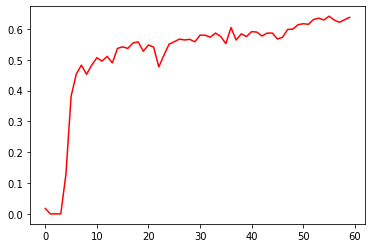

Loss visualization:


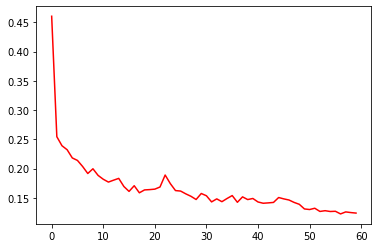

Accuracy visualization:


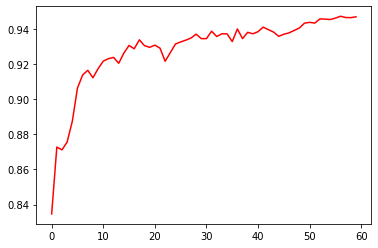

In [15]:
train_mode = True

criterion = torch.nn.BCELoss()
model = MANet(in_ch, out_ch).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

if train_mode == True:
  model = train_model(model, criterion, optimizer, dataloaders, epochs)
else:
  # load best saved checkpoint
  model = torch.load(model_dir + model_file)

# Visualize Predicted Label Images in Test Set

In [17]:
from glob import glob

x_test_dir = os.path.join(data_dir, 'test_img')
test_files = glob(x_test_dir + '/*.png')

prediction_threshold = 0.4

model.eval()

for f in test_files:
    image = cv2.imread(f, cv2.IMREAD_COLOR)
    input = image.transpose(2, 0, 1).astype('float32')
    x_tensor = torch.from_numpy(input).to(device).unsqueeze(0)

    prediction = model(x_tensor)
    prediction = (prediction > prediction_threshold).long().squeeze().cpu().numpy().round()

    rgb = input.transpose(1, 2, 0)

    plt.figure(figsize=(12,12))
    plt.subplot(1,2,1)
    plt.imshow(rgb[:,:,[2,1,0]]/255)
    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.show()

    rgb_fname = pathlib.Path(f).stem
    prediction = (prediction*255).astype('uint8')
    prediction = cv2.resize(prediction, (512, 512), interpolation=cv2.INTER_CUBIC)
    # save prediction with the original image size
    cv2.imwrite(pred_dir + rgb_fname + '.png', prediction)

Output hidden; open in https://colab.research.google.com to view.